In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import jax.numpy as jnp
from jax import random, vmap, pmap, local_devices

import numpy as np
from jax import image

from models import VAE
from archs import MLP, periodic_encoding
from utils import restore_checkpoint

from configs.default import get_config

import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
%matplotlib inline

print(local_devices())

2023-01-21 13:45:54.494245: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
N = 4096
m = 64
num_channels = 1

resize = lambda x: image.resize(x, shape=(m,m,num_channels), method='bilinear')

data_buf = np.load('../datasets/cahn_hilliard_patterns.npy')
num_examples = data_buf.shape[0]

key = random.PRNGKey(0)
idx = random.choice(key, num_examples, (N,), replace=False)
train_X = jnp.array(data_buf[idx,...])
train_X = vmap(resize)(train_X)

key = random.PRNGKey(1)
idx = random.choice(key, num_examples, (N,), replace=False)
test_X = jnp.array(data_buf[idx,...])
test_X = vmap(resize)(test_X)

def get_example(u, X, n):
    u = jnp.flipud(u)
    s = u.reshape(-1,1)
    return u, X, s, jnp.tile(1.0, (X.shape[0],1))

N, m, _, num_channels = train_X.shape

x = np.linspace(0,1,m)
y = np.linspace(0,1,m)
grid = np.meshgrid(x,y)
X = jnp.array(grid).T.reshape(-1,2)

# Generate training samples
key = random.PRNGKey(0)
keys = random.split(key, N)
gen_fn = lambda u: get_example(u, X, m)
u_train, y_train, s_train, w_train = vmap(gen_fn)(train_X)
print('Training data')
print('u: {}'.format(u_train.shape))
print('y: {}'.format(y_train.shape))
print('s: {}'.format(s_train.shape))
print('w: {}'.format(w_train.shape))

# Generate testing samples
key = random.PRNGKey(1)
keys = random.split(key, N)
gen_fn = lambda u: get_example(u, X, m)
u_test, y_test, s_test, w_test = vmap(gen_fn)(test_X)
print('Testing data')
print('u: {}'.format(u_test.shape))
print('y: {}'.format(y_test.shape))
print('s: {}'.format(s_test.shape))
print('w: {}'.format(w_test.shape))

Training data
u: (4096, 64, 64, 1)
y: (4096, 4096, 2)
s: (4096, 4096, 1)
w: (4096, 4096, 1)
Testing data
u: (4096, 64, 64, 1)
y: (4096, 4096, 2)
s: (4096, 4096, 1)
w: (4096, 4096, 1)


In [3]:
# Load trained model
config = get_config()
model = VAE(config)
model = restore_checkpoint(model, '../checkpoints/ch_ConcatDecoder_h256_eps64_beta1e-4_checkpoint_20000')


                             NeuralOperator Summary                             
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ NeuralOperat… │ -             │ float32[1,1] │               │
│               │               │ float32[1,64… │              │               │
│               │               │ -             │              │               │
│               │               │ float32[1,2]  │              │               │
│               │               │ -             │              │               │
│               │               │ float32[128]  │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ encoder       │ ConvEncoder   │ -             │ -            │               │
│               │          

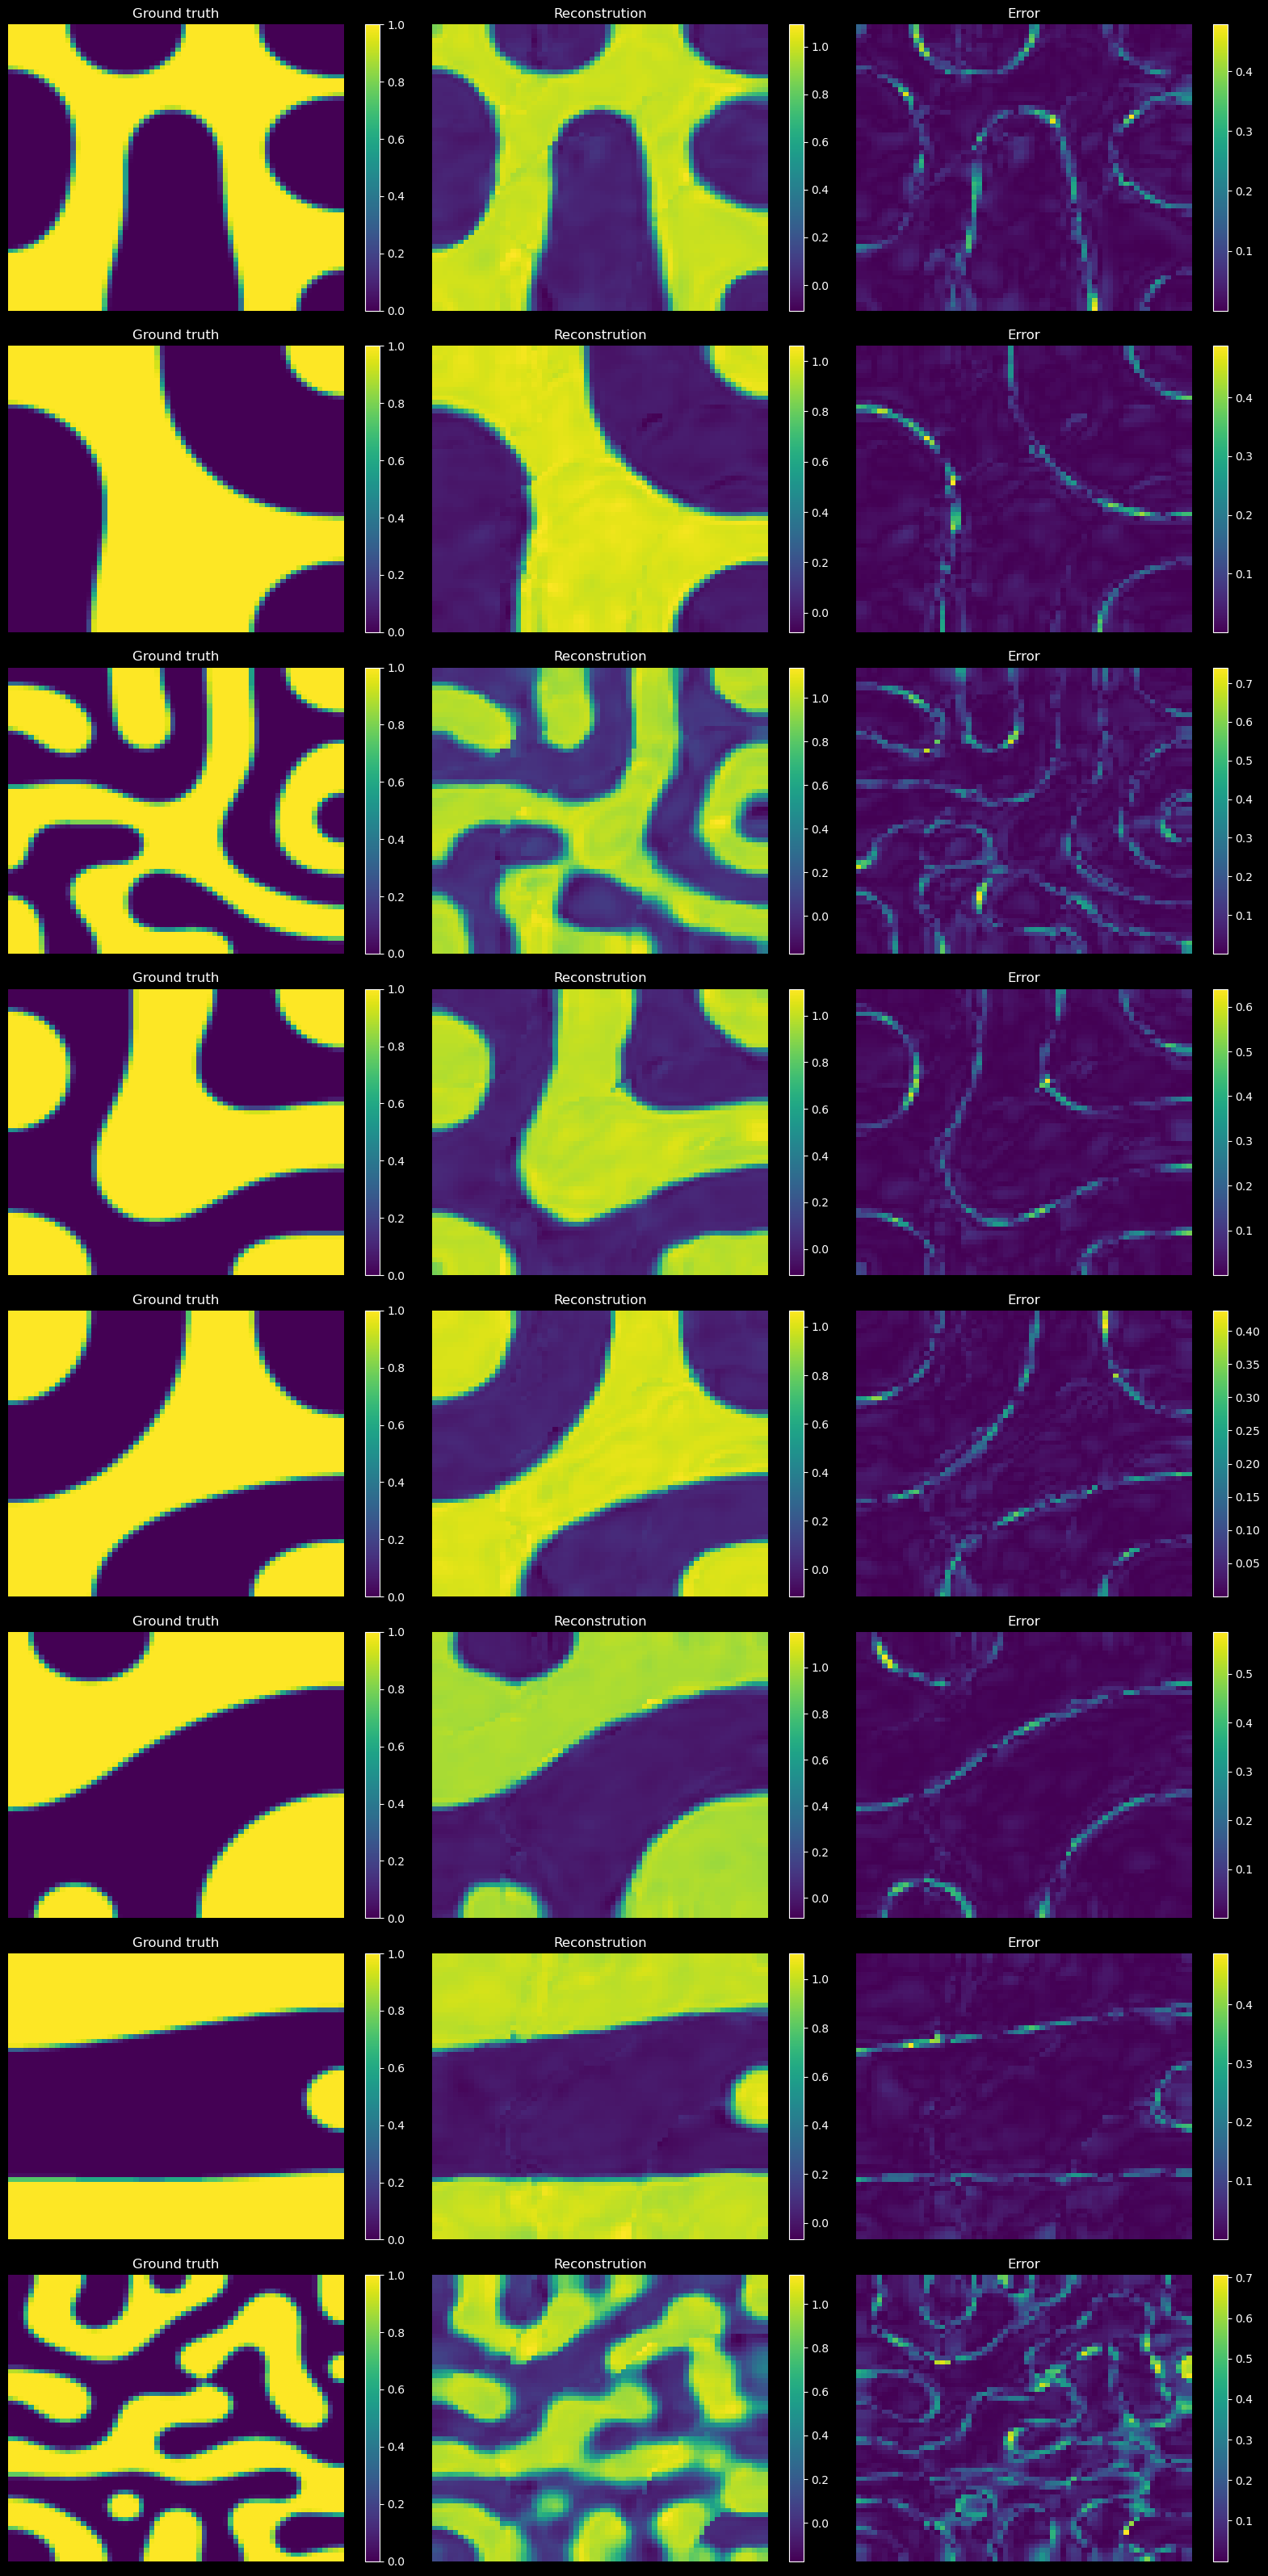

In [4]:
# Train reconstructions
num_samples = 8
key = random.PRNGKey(0)
idx = random.choice(key, N, (num_samples,), replace=False)
eps_train= random.normal(key, (num_samples, config.eps_dim))
pred_fn = lambda params: model.state.apply_fn(params, u_train[idx,...], y_train[idx,...], eps_train)
s_pred = pmap(pred_fn)(model.state.params)[0,...]

num_samples = 8
plt.figure(figsize=(16, num_samples*4))
cnt=0
for i in range(num_samples):
    # Grounf truth
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_train[idx[i],...].reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Ground truth')
    # Prediction
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_pred[i,...].reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Reconstrution')
    # Error
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    error = jnp.abs(s_train[idx[i],...] - s_pred[i,...])
    plt.pcolor(grid[0], grid[1], error.reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Error')
plt.tight_layout()
plt.savefig('./figures/train_reconstructions.png', dpi=300)
plt.show()

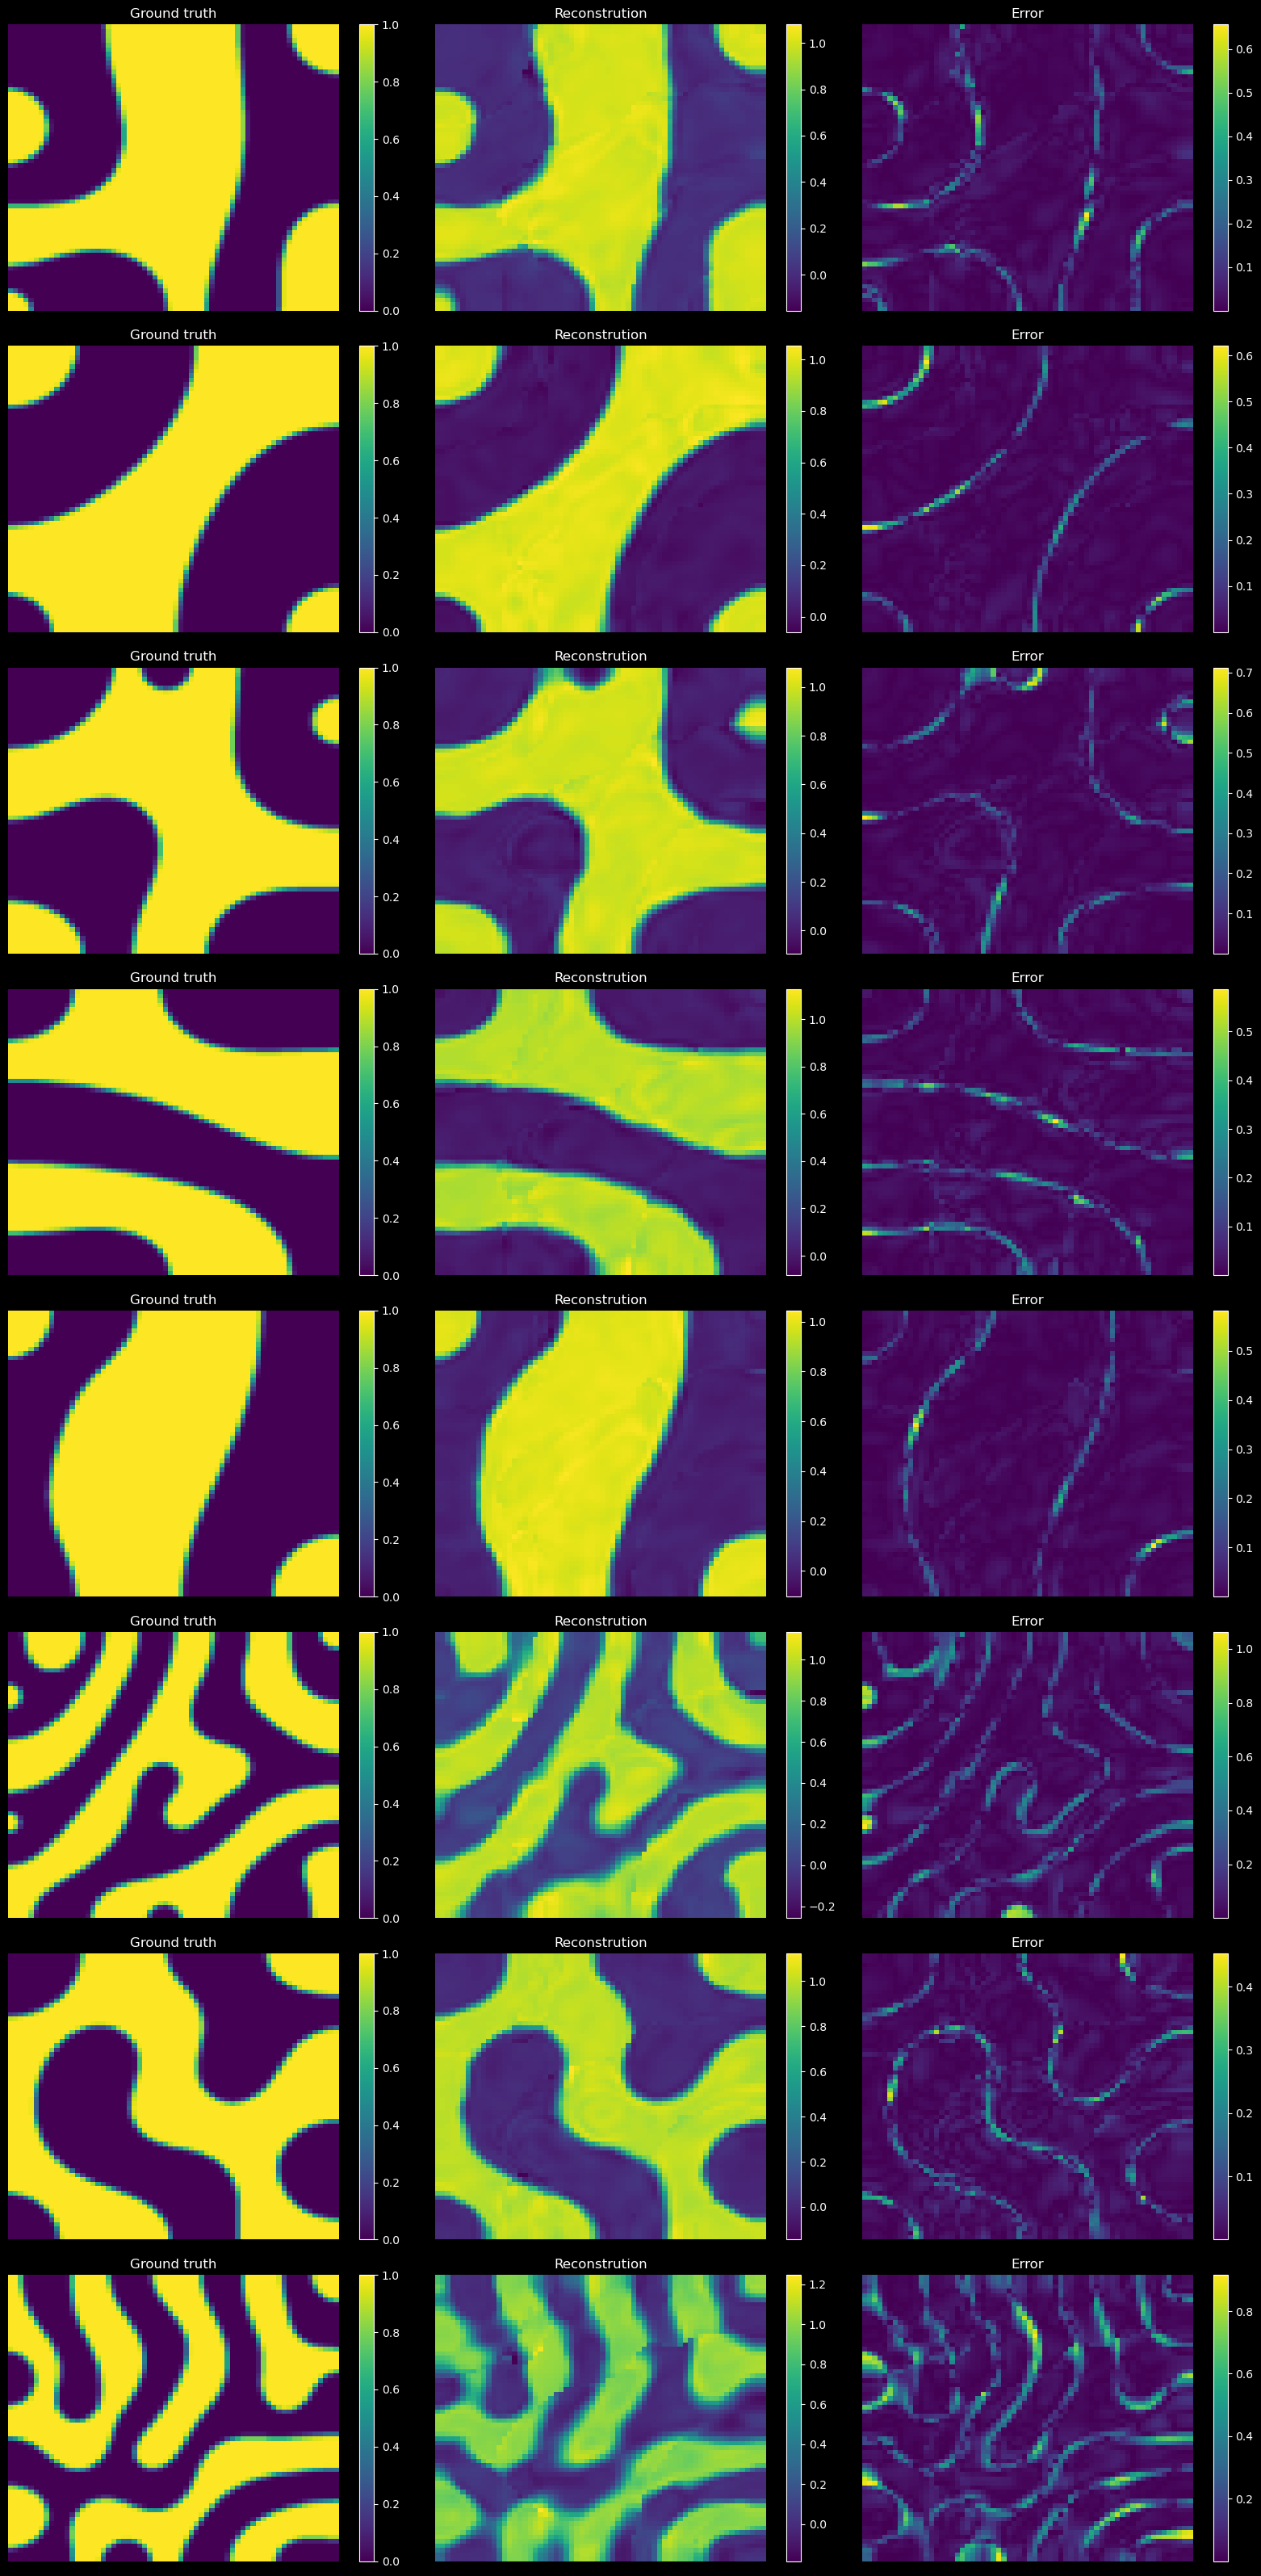

In [5]:
# Test reconstructions
num_samples = 8
key = random.PRNGKey(123)
idx = random.choice(key, N, (num_samples,), replace=False)
eps_test = random.normal(key, (num_samples, config.eps_dim))
pred_fn = lambda params: model.state.apply_fn(params, u_test[idx,...], y_test[idx,...], eps_test)
s_pred = pmap(pred_fn)(model.state.params)[0,...]

plt.figure(figsize=(16, num_samples*4))
cnt=0
for i in range(num_samples):
    # Grounf truth
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_test[idx[i],...].reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Ground truth')
    # Prediction
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    plt.pcolor(grid[0], grid[1], s_pred[i,...].reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Reconstrution')
    # Error
    cnt+=1
    plt.subplot(num_samples, 3, cnt)
    error = jnp.abs(s_test[idx[i],...] - s_pred[i,...])
    plt.pcolor(grid[0], grid[1], error.reshape(m,m).T)
    plt.colorbar()
    plt.axis('off')
    plt.title('Error')
plt.tight_layout()
plt.savefig('./figures/test_reconstructions.png', dpi=300)
plt.show()

(8, 4096, 1)


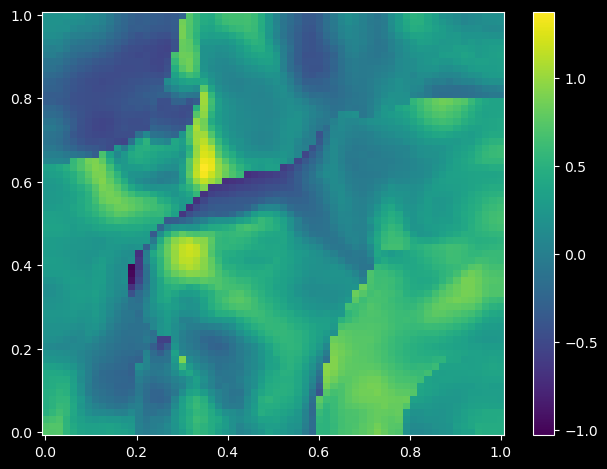

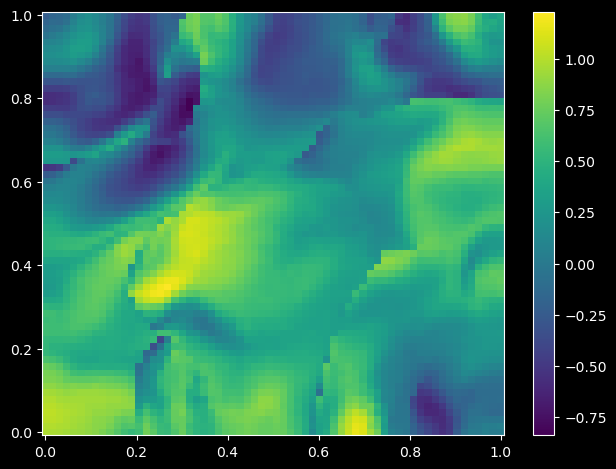

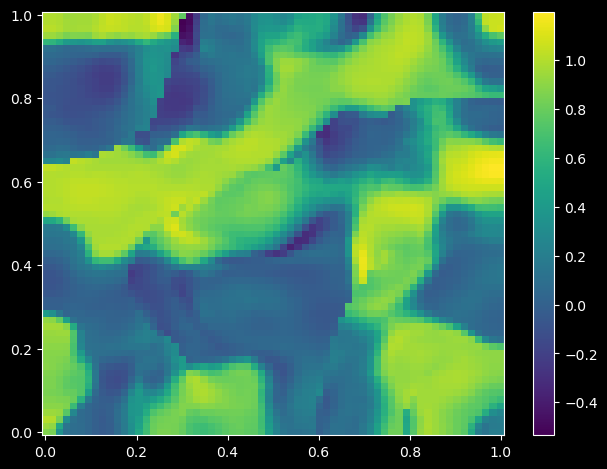

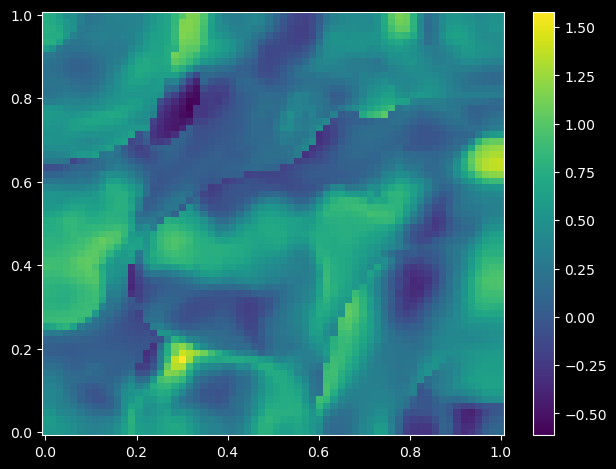

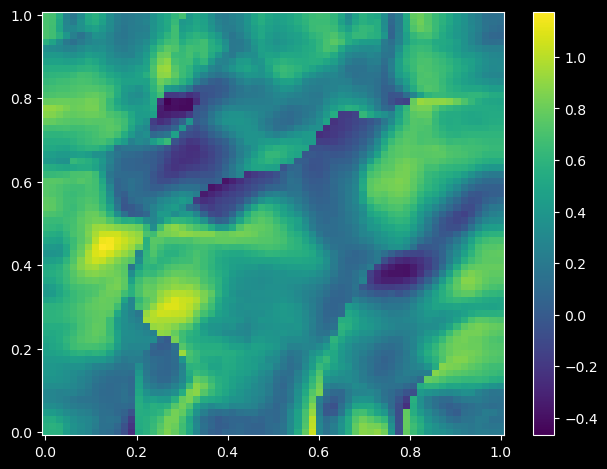

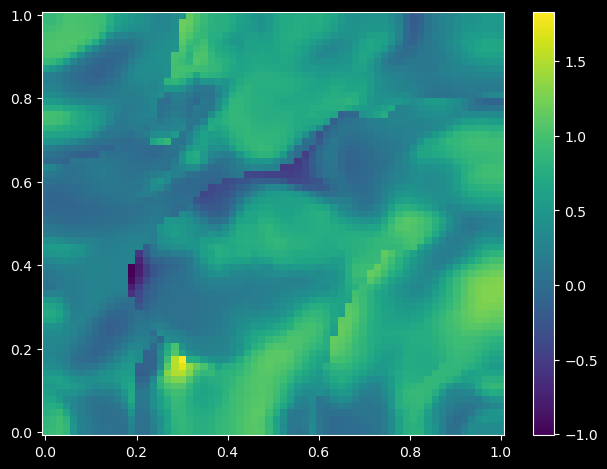

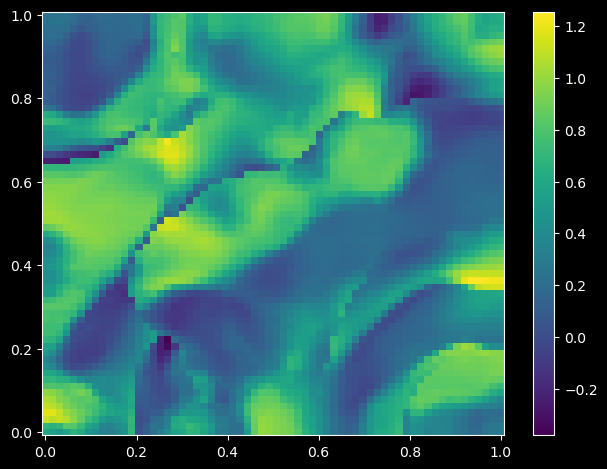

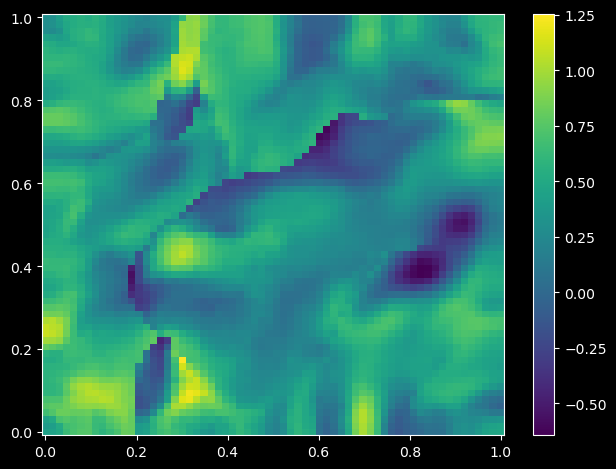

In [6]:
# Generate samples
num_samples = 8

# Super-resolution grid
mm = 64
x = jnp.linspace(0,1,mm)
y = jnp.linspace(0,1,mm)
test_grid = jnp.meshgrid(x,y)
y_test = jnp.array(test_grid).T.reshape(-1,2)
y_test = jnp.tile(y_test, (N,1,1))

key = random.PRNGKey(123)
eps_test = random.normal(key, (num_samples, config.eps_dim))
sample_fn = lambda params: model.state.decode_fn(params, eps_test, y_test[:num_samples,...])
samples = pmap(sample_fn)(model.state.params)[0,...]
print(samples.shape)

for i in range(num_samples):
    plt.figure()
    plt.pcolor(test_grid[0], test_grid[1], samples[i,...].reshape(mm,mm).T)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('./figures/sample_%d.png' % (i+1), dpi=300)
    plt.show()